In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import os
import numpy as np
import scipy
from scipy import stats
import jax.numpy as jnp

dpi = 300
mpl.rcParams['figure.dpi']= dpi
%config InlineBackend.figure_format = 'retina'

# import seaborn as sns
# sns.set()

import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "png")
# plt.tight_layout()
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["font.size"] = 28
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 7
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
eps = 1e-6

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


<ipython-input-1-d9c35d74e4b8>:46: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [11]:
dataset = 'mnist'
method_list = ['ntk_norm', 'f_norm', 'jac_norm', 'map']
train_size = '10000'
seed = 1

cmap = plt.get_cmap("tab20c")
blue = plt.get_cmap("Set1")(1)
red = plt.get_cmap("Set1")(0)
cmap_2 = plt.get_cmap("tab10")
cmap_3 = plt.get_cmap("Paired")
cmap_4 = plt.get_cmap("tab20b")

color_dict = {'ntk_norm': red,
             'f_norm': 'orange',
             'jac_norm': blue,
             'map': 'darkgreen',
             'map_no_wd': 'grey',
             'kernel': 'purple',
             'dropout': 'brown'}

linestyle_dict = {'True': '-',
                 'False': ':'}


directory = '/home/xzhoubi/hudson/function_map/results/mnist'

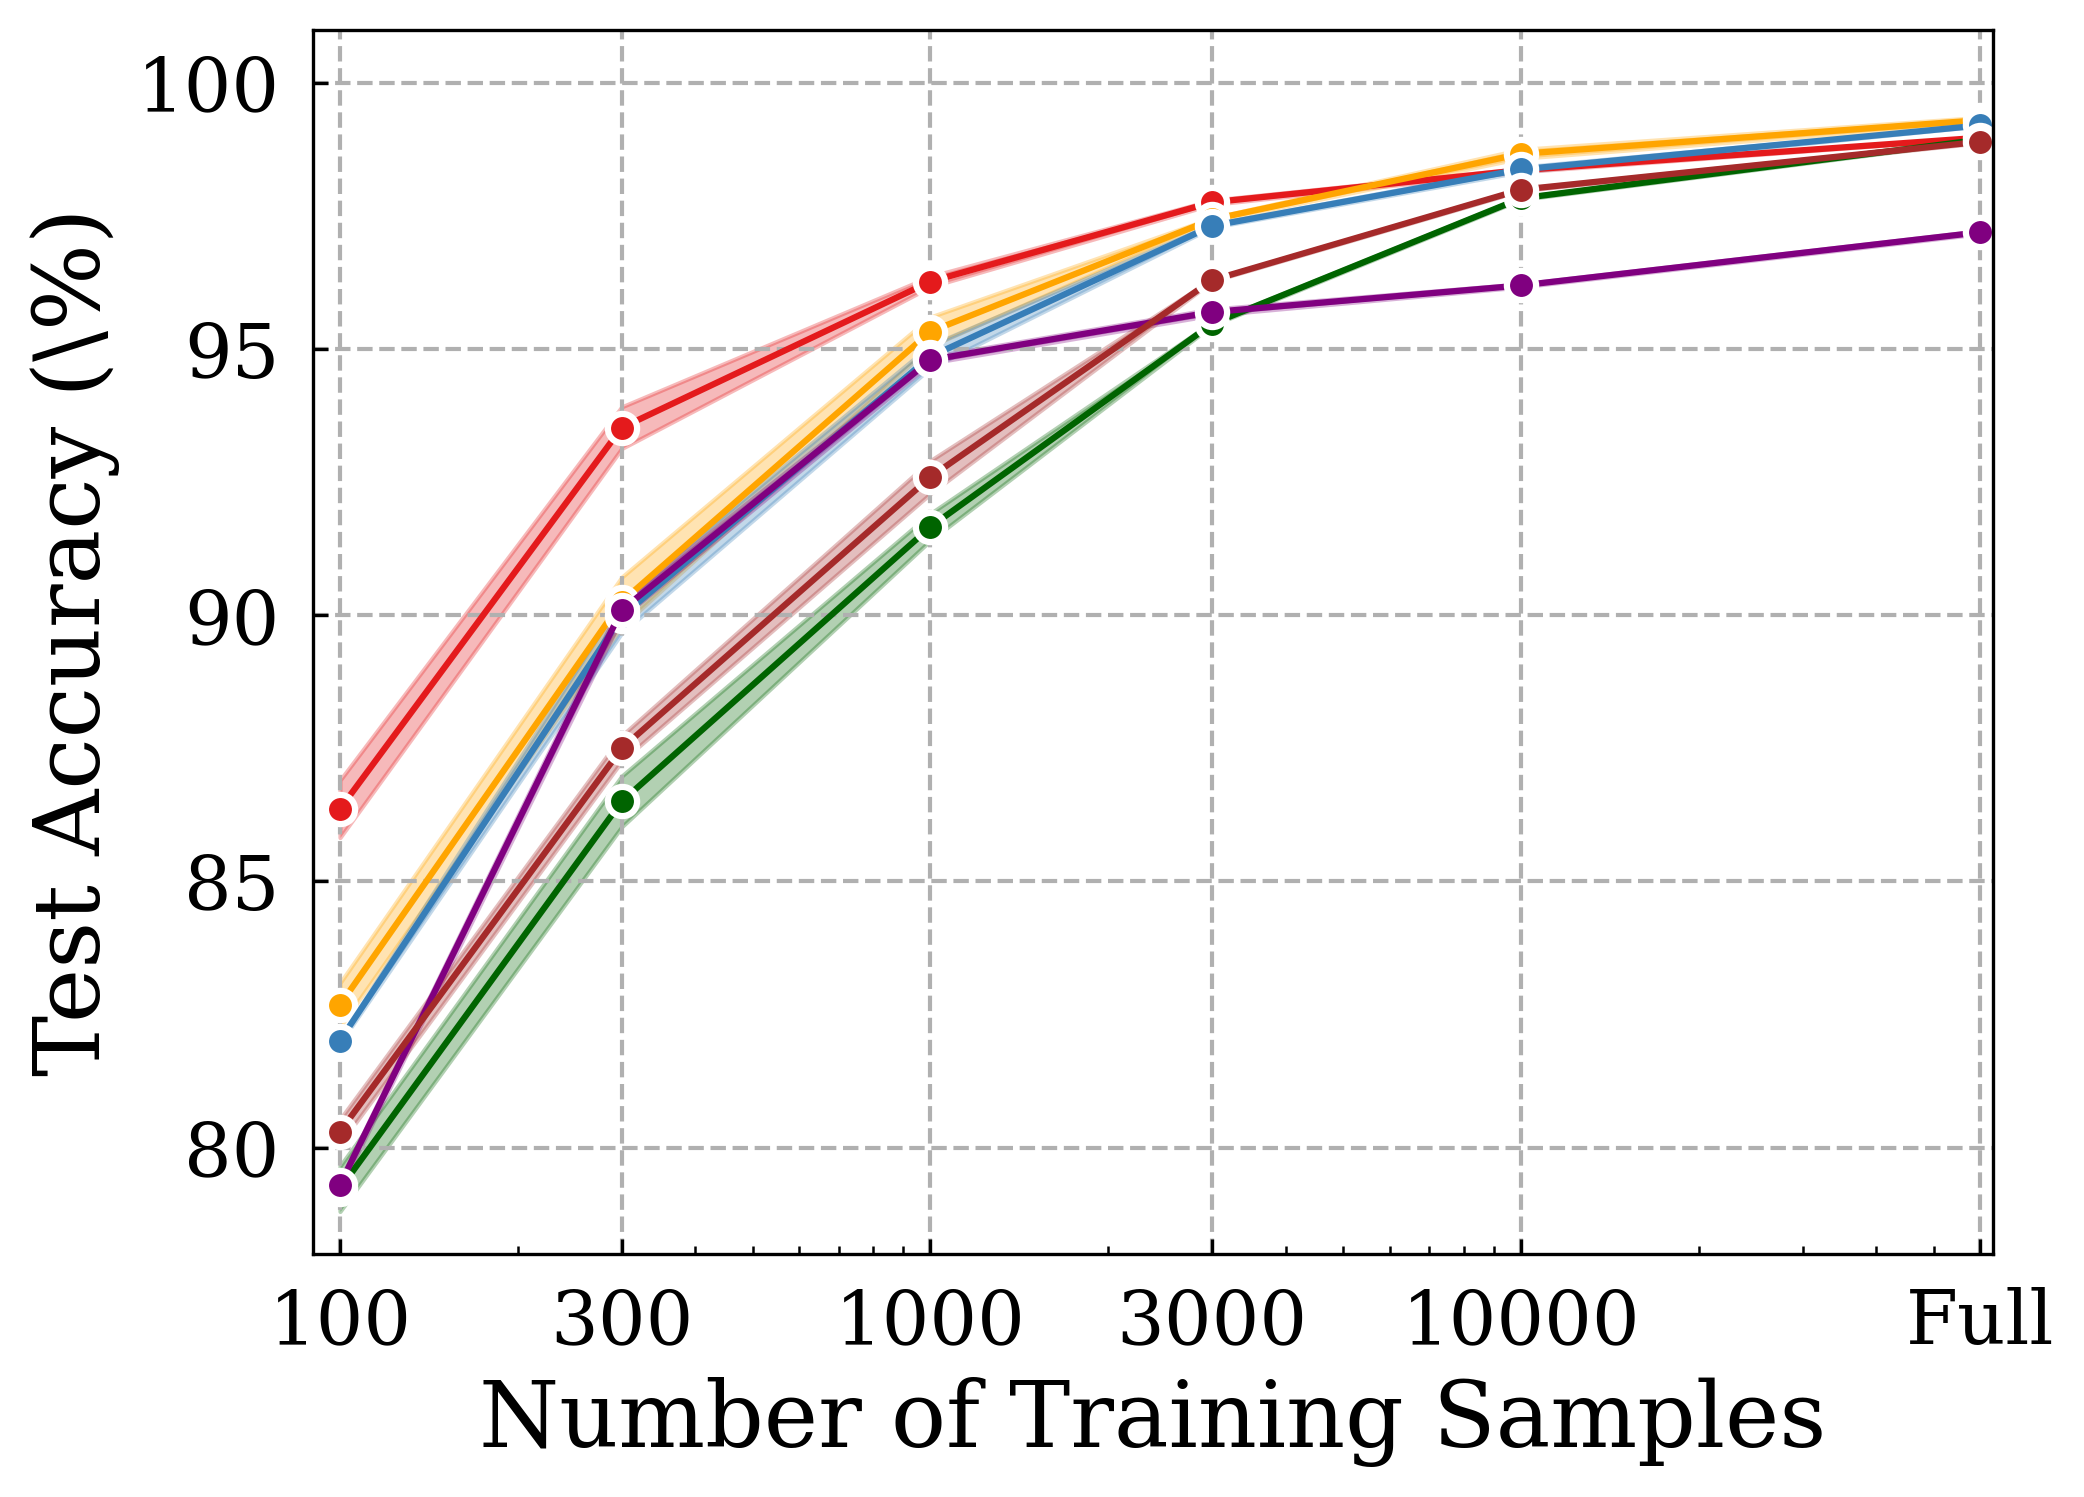

In [15]:
fig = plt.figure(figsize=(8, 6))
ax_test_acc = fig.subplots(1, 1)

ax_list = [ax_test_acc]

train_size_list = [100, 300, 1000, 3000, 10000, 60000]
test_acc_dict = {'ntk_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'f_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'jac_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'map': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'kernel': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'dropout': {'mean': np.array([80.3, 87.5, 92.6, 96.3, 98.0, 98.9]),
                            'ste': np.array([0.23, 0.24, 0.31, 0.02, 0.02, 0.02])}}
                 
test_ece_dict = {'ntk_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'f_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'jac_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'map': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'kernel': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'dropout': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},}
                 
test_llk_dict = {'ntk_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'f_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'jac_norm': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'map': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'kernel': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},
                'dropout': {'mean': np.zeros(len(train_size_list)),
                             'ste': np.zeros(len(train_size_list))},}


for i in range(len(train_size_list)):
    train_size = int(train_size_list[i])
    acc_array = jnp.load(f'./function_map/results/kernel_reg_mnist/acc_{train_size}_1.0.npy') * 100
    test_acc_dict['kernel']['mean'][i] = acc_array.mean()
    test_acc_dict['kernel']['ste'][i] = stats.sem(acc_array) / 10

test_acc_dict['kernel']['mean'][i] += 1

for i in range(len(train_size_list)):
    train_size = train_size_list[i]
    for method in method_list:
        test_acc_list_temp = []
        test_ece_list_temp = []
        test_llk_list_temp = []
        for filename in os.listdir(directory):
            if (("dataset_" + dataset) in filename and ("method_" + method + '__') in filename 
            and ("train_size_" + str(train_size) + '_') in filename 
            and "complete" in filename):
#                 print(filename)
                data = pd.read_csv(f'{directory}/{filename}/metrics.csv')

                test_llk = data['Test LLK'].values[-1]
                test_acc = data['Test Acc'].values[-1]
                test_ece = data['Test ECE'].values[-1]

                test_acc_list_temp.append(test_acc)
                test_ece_list_temp.append(test_ece)
                test_llk_list_temp.append(test_llk)
    
        test_acc_dict[method]['mean'][i] = np.array(test_acc_list_temp).mean()
        test_acc_dict[method]['ste'][i] = stats.sem(np.array(test_acc_list_temp))
        test_ece_dict[method]['mean'][i] = np.array(test_ece_list_temp).mean()
        test_ece_dict[method]['ste'][i] = stats.sem(np.array(test_ece_list_temp))
        test_llk_dict[method]['mean'][i] = np.array(test_llk_list_temp).mean()
        test_llk_dict[method]['ste'][i] = stats.sem(np.array(test_llk_list_temp))
    
    
for method in method_list:
    ax_test_acc.plot(np.array(train_size_list), test_acc_dict[method]['mean'], 
                     marker='o',
                     ms=7, markerfacecolor=color_dict[method], markeredgecolor='white', markeredgewidth=1.5, 
                     color = color_dict[method], label=method)
    ax_test_acc.fill_between(np.array(train_size_list), test_acc_dict[method]['mean'] - test_acc_dict[method]['ste'],
                             test_acc_dict[method]['mean'] + test_acc_dict[method]['ste'],
                     color = color_dict[method], alpha=0.3)
    
ax_test_acc.plot(np.array(train_size_list), test_acc_dict['kernel']['mean'], 
                 marker='o',
                 ms=7, markerfacecolor=color_dict['kernel'], markeredgecolor='white', markeredgewidth=1.5, 
                 color = color_dict['kernel'], label='kernel', linestyle='-')
ax_test_acc.fill_between(np.array(train_size_list), test_acc_dict['kernel']['mean'] - test_acc_dict['kernel']['ste'],
                         test_acc_dict['kernel']['mean'] + test_acc_dict['kernel']['ste'],
                 color = color_dict['kernel'], alpha=0.3)
         
ax_test_acc.plot(np.array(train_size_list), test_acc_dict['dropout']['mean'], 
                 marker='o',
                 ms=7, markerfacecolor=color_dict['dropout'], markeredgecolor='white', markeredgewidth=1.5, 
                 color = color_dict['dropout'], label='dropout', linestyle='-')
ax_test_acc.fill_between(np.array(train_size_list), test_acc_dict['dropout']['mean'] - test_acc_dict['dropout']['ste'],
                         test_acc_dict['dropout']['mean'] + test_acc_dict['dropout']['ste'],
                 color = color_dict['dropout'], alpha=0.3)

for ax in ax_list:
#     ax.legend()
    ax.set_xscale("log")
    ax.set_xlabel(r"Number of Training Samples")
    ax.set_ylabel(r"Test Accuracy (\%)")
    ax.set_xlim([90, 63000])
    ax.set_ylim([78, 101])
    ax.set_yticks([80, 85, 90, 95, 100])
    ax.set_xticks([100, 300, 1e3, 3e3, 1e4, 6e4])
    ax.set_xticklabels([100, 300, '1000', '3000', '10000', 'Full'])

fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(left=0.2)
fig.savefig('./function_map/aistats_plot/mnist.pdf')
